In [1]:
import csv
import cvxopt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Hard Margin Case

Importing dataset

In [2]:
X_orig = np.genfromtxt("../data/X.csv", delimiter=',')
y = np.genfromtxt("../data/y.csv", delimiter=',')

## Normalizing the X features

In [3]:
X = (X_orig - X_orig.mean())/ X_orig.std()

### Plotting the data points

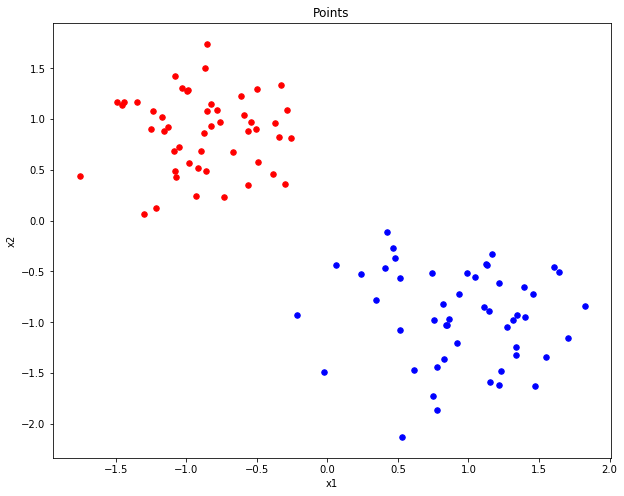

In [4]:
idx_1 = np.where(y==1)
idx_2 = np.where(y==-1)

plt.figure(figsize=(10,8))
plt.scatter(X[idx_1,0], X[idx_1,1], s=30, c='b', marker="o")
plt.scatter(X[idx_2,0], X[idx_2,1], s=30, c='r', marker="o")
plt.title("Points")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [5]:
class Linear_svm:
    
    def __init__(self):
        self.soln = None
    
    def fit(self, X, y):
        cvxopt.solvers.options['show_progress'] = False
        
        N,F = X.shape
        identity_matrix = np.identity(N)
        Q = np.zeros([F+1, F+1])

        for r,row in enumerate(Q):
            for c,elem in enumerate(row):
                if r == 0 or c == 0:
                    Q[r][c] = 0
                else:
                    Q[r][c] = identity_matrix[r-1][c-1]

        e_list = []
        for n in range(N):
            zero_matrix = np.zeros(F+1)
            for i in range(len(zero_matrix)):
                if i == 0:
                    zero_matrix[i] = 1
                else:
                    zero_matrix[i] = (X[n].T)[i-1]
            e_list.append(y[n]*zero_matrix)
        
        e_list = np.array(e_list)*-1.
        G = cvxopt.matrix(e_list)       
        P = cvxopt.matrix(Q)
        q = cvxopt.matrix(np.zeros(F+1))
        h = cvxopt.matrix(np.ones(N)*-1.)
        
        # Solving the Quadratic Programming Problem
        self.soln =  cvxopt.solvers.qp(P, q, G, h)

In [6]:
linear_svm = Linear_svm()
linear_svm.fit(X, y)

In [7]:
linear_svm.soln

{'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <100x1 matrix, tc='d'>,
 'z': <100x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 9.798040873651916e-08,
 'relative gap': 3.42338996845954e-08,
 'primal objective': 2.862087372259224,
 'dual objective': 2.8620872772086927,
 'primal infeasibility': 5.118427737208041e-10,
 'dual infeasibility': 5.474242912553206e-08,
 'primal slack': 9.185140186553616e-11,
 'dual slack': 5.868541896987318e-11,
 'iterations': 6}

## Printing our model parameters

In [8]:
params = np.array(linear_svm.soln['x'])
w0 = params[0][0]
w = [params[1][0], params[2][0]]
print(f"w = {w}")
print(f"b = {w0}")

w = [1.595810412811248, -1.7825722624571614]
b = 0.1209383482647966


## Comparing our model with a sklearn.svm.SVC Classifier

In [9]:
from sklearn.svm import SVC

clf = SVC(C = 1000, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)

w =  [[ 1.59608347 -1.78216121]]
b =  [0.12094717]


**So our results of the model parameters are pretty close to the model parameters generated by the sklearn.svm.SVC Classifier**

### Plotting the decision boundary

In [10]:
def plot_data_with_decision_boundary(X, y, w, w0,
                                     fig_size=(12, 9),
                                     labels=['x1', 'x2']):
    plt.figure(figsize=fig_size)
    pos_idx = np.where(y==1)
    neg_idx = np.where(y==-1)

    plt.scatter(X[pos_idx,0], X[pos_idx,1], s=30, c='b', marker="o")
    plt.scatter(X[neg_idx,0], X[neg_idx,1], s=30, c='r', marker="x")

    slope = -w[0]/w[1]
    intercept = w0/w[1]
    print(f"slope is {slope}, intercept is {intercept}")
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.title("Linear SVM")
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.plot(x_vals, y_vals, '--')

slope is 0.895229016192323, intercept is -0.06784485028286644


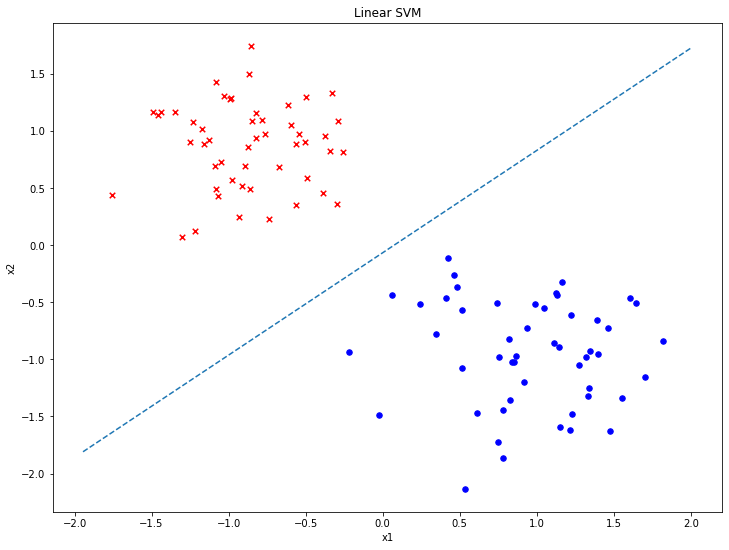

In [11]:
plot_data_with_decision_boundary(X, y, w, w0)

Determine which points are closest to the decision boundary. What is the functional margin of the points closest to the decision boundary?   

In [12]:
def get_support_vectors(X, w, w0):
    """
    The Hyperplane is w.Tx + w0 = 0
    dist f(x) = w.Tx + w0
    """
    w = np.array(w)
    f_x = X@w.T + w0
    w_norm = np.linalg.norm(w, 2) # L2 norm
    dist_r = f_x / w_norm
    dist_r = abs(dist_r)
    min_dist = min(dist_r)
    
    print(f"Minimum distance is {min_dist}")
    return np.where(np.isclose(dist_r, min_dist))

## The Support vectors are at indexes 25, 49 and 68

**This is exactly what the sklearn.SVM.svc predicted as well**

In [13]:
print("Custom Model: Indices of Support Vectors = ", get_support_vectors(X, w, w0))

Minimum distance is 0.41796850539946045
Custom Model: Indices of Support Vectors =  (array([25, 49, 68]),)


## Indices of Support Vectors as predicted by sklearn.SVM.svc

In [14]:
print('sklearn model: Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))

sklearn model: Indices of support vectors =  [68 25 49]
Support vectors =  [[-0.29692537  0.36301572]
 [ 0.06232012 -0.43735144]
 [ 0.42248931 -0.11491754]]
Number of support vectors for each class =  [1 2]
Coefficients of the support vector in the decision function =  [[2.86193888 1.28505545 1.57688343]]


Write the decision function $f_{\texttt{primal}}({\bf x})$ to predict examples.  Use this function to predict the label of $(3.0, 1.5)^T$ and $(1.2, 3.0)^T$

In [15]:
def f_primal(X, w, w0):
    w = np.array(w)
    f_x = X@w.T + w0
    return np.where(f_x>0, 1, -1)

In [16]:
a = np.array([3.0,1.5]).reshape(1,-1)
b = np.array([1.2,3.0]).reshape(1,-1)

In [17]:
print(f"The predicted value for {a} is {f_primal(a, w, w0)[0]}")

The predicted value for [[3.  1.5]] is 1


In [18]:
print(f"The predicted value for {b} is {f_primal(b, w, w0)[0]}")

The predicted value for [[1.2 3. ]] is -1


In [19]:
def plot_predictions(X, w, w0):
    plt.figure(figsize=(12,8))
    
    y_pred = f_primal(X, w, w0)
    pos_idx = np.where(y_pred==1)
    neg_idx = np.where(y_pred==-1)

    plt.scatter(X[pos_idx,0], X[pos_idx,1], s=30, c='b', marker="o")
    plt.scatter(X[neg_idx,0], X[neg_idx,1], s=30, c='r', marker="x")

    slope = -w[0]/w[1]
    intercept = w0/w[1]
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.title("Linear SVM")
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.plot(x_vals, y_vals, '--')
    

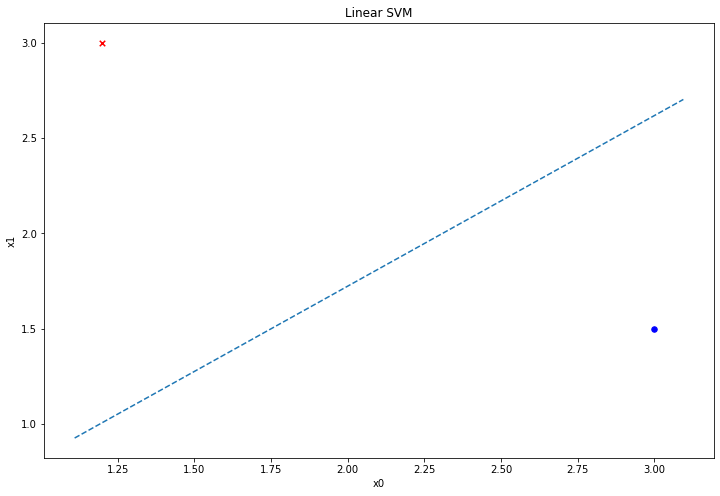

In [20]:
plot_predictions(np.concatenate([a,b]), w, w0)